# Testing new AMM


In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

# Experiments
from model import run
from model import processing
#from model.plot_utils import *
from model import plot_utils as pu
from model import init_utils



########## AGENT CONFIGURATION ##########
# key -> token name, value -> token amount owned by agent
# note that token name of 'omniABC' is used for omnipool LP shares of token 'ABC'
# omniHDXABC is HDX shares dedicated to pool of token ABC
LP1 = {'omniR1': 500000}
LP2 = {'omniR2': 1500000}
trader = {'HDX': 1000000, 'R1': 1000000, 'R2': 1000000}

# key -> agent_id, value -> agent dict
agent_d = {'Trader': trader, 'LP1': LP1, 'LP2': LP2}
#agent_d = {'Trader': trader, 'LP1': LP1}


########## ACTION CONFIGURATION ##########

action_dict = {
    'sell_hdx_for_r1': {'token_buy': 'R1', 'token_sell': 'HDX', 'amount_sell': 2000, 'action_id': 'Trade', 'agent_id': 'Trader'},
    'sell_r1_for_hdx': {'token_sell': 'R1', 'token_buy': 'HDX', 'amount_sell': 1000, 'action_id': 'Trade', 'agent_id': 'Trader'}
}

# list of (action, number of repititions of action), timesteps = sum of repititions of all actions
block_count = 100
action_ls = [('trades', block_count)]

# maps action_id to action dict, with some probability to enable randomness
prob_dict = {
    'trades': {
        'trade_types': {'sell_hdx_for_r1': 0.5, 'sell_r1_for_hdx': 0.5},
        'n': 2}
}



########## CFMM INITIALIZATION ##########

# Todo: generalize
initial_values = {
    'token_list': ['R1','R2'],
    'R': [500000,1500000],
    'P': [2,2/3],
    'fee_assets': 0,
    'fee_HDX': 0
}
#initial_values['H'] = [initial_values['Q'] * initial_values['W'][i] for i in range(len(initial_values['token_list']))]
#initial_values['D'] = copy.deepcopy(initial_values['H'])

#amms = [balancer_amm, reweighting_amm]
#amm_types = ['Balancer', 'Reweighting']
#amms = [reweighting_amm]
#amm_types = ['Reweighting']
#labels = amm_types
initial_list = []
config_params = {
    #'amm': amm,
    'cfmm_type': "",
    'initial_values': initial_values,
    'agent_d': agent_d,
    'action_ls': action_ls,
    'prob_dict': prob_dict,
    'action_dict': action_dict,
}

config_dict, state = init_utils.get_configuration(config_params)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.07s


In [2]:
rdf, agent_df = processing.postprocessing(events)


In [3]:
%matplotlib inline



In [4]:
rdf.head(20)

,R-0,R-1,Q-0,Q-1,S-0,S-1,A-0,A-1,B-0,B-1,...,token_list-0,token_list-1,fee_assets,fee_HDX,n,simulation,subset,run,substep,timestep
3,499998.00,1500000,1000003.99,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,1
6,500000.01,1500000,999999.98,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,2
9,500002.00,1500000,999995.99,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,3
12,500003.99,1500000,999992.02,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,4
15,500001.98,1500000,999996.04,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,5
18,502001.98,1500000,996012.01,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,6
21,501991.97,1500000,996031.87,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,7
24,499984.06,1500000,1000031.87,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,8
27,497992.16,1500000,1004031.87,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,9
30,498002.15,1500000,1004011.74,1000000.00,500000,1500000,0.00,0,0,0,...,R1,R2,0,0,2,0,0,1,3,10


In [5]:
agent_df.tail(20)

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,r-0,r-1,p-0,p-1
847,0,0,1,3,94,LP1,0.00,500000,0,0.00,0,2.00,0.00
848,0,0,1,3,94,LP2,0.00,0,1500000,0.00,0,0.00,0.67
855,0,0,1,3,95,Trader,993691.16,0,0,1002991.24,1000000,0.00,0.00
856,0,0,1,3,95,LP1,0.00,500000,0,0.00,0,2.00,0.00
857,0,0,1,3,95,LP2,0.00,0,1500000,0.00,0,0.00,0.67
864,0,0,1,3,96,Trader,991691.16,0,0,1003942.01,1000000,0.00,0.00
865,0,0,1,3,96,LP1,0.00,500000,0,0.00,0,2.00,0.00
866,0,0,1,3,96,LP2,0.00,0,1500000,0.00,0,0.00,0.67
873,0,0,1,3,97,Trader,993785.92,0,0,1002942.01,1000000,0.00,0.00
874,0,0,1,3,97,LP1,0.00,500000,0,0.00,0,2.00,0.00


## Analysis

[0]


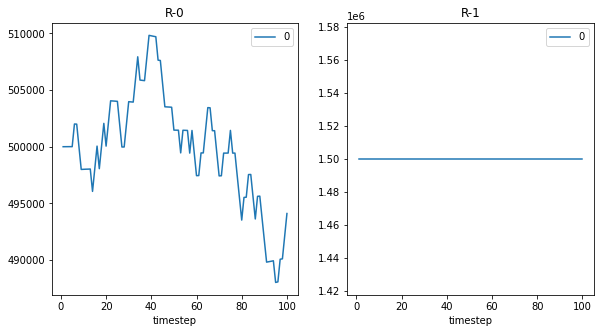

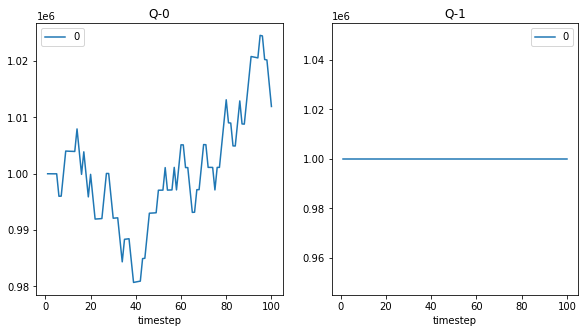

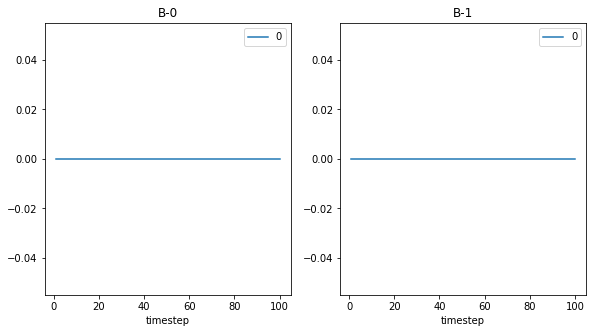

In [6]:
var_list = ['R', 'Q', 'B']
pu.plot_vars(rdf, var_list)


[0]


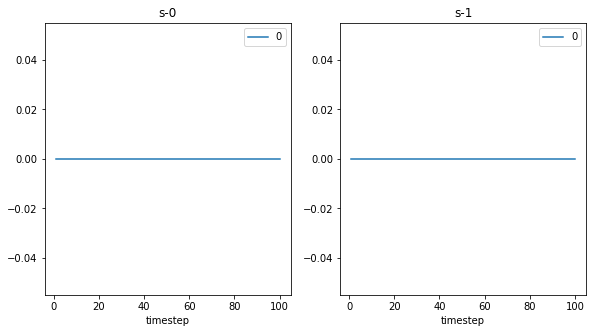

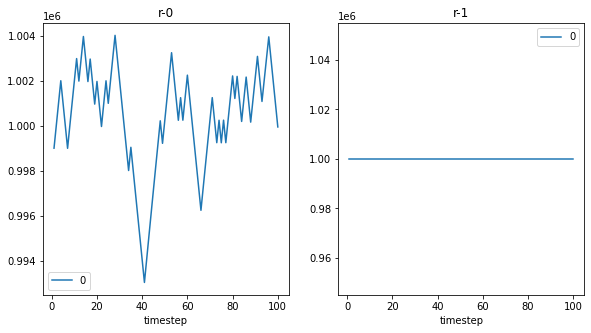

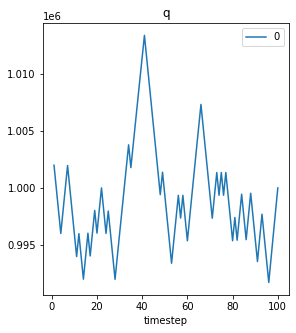

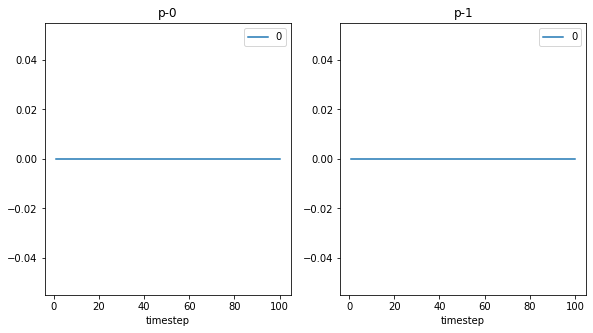

In [7]:
var_list = ['s', 'r', 'q', 'p']
trader_df = agent_df[agent_df['agent_label'] == 'Trader']
pu.plot_vars(trader_df, var_list)


In [8]:
# merge agent_df, rdf to one df on timesteps, run, etc

merged_df = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])

In [9]:
# add IL column to agent DF, where val_hold is calculated using initial holdings from agent_d
#val hold: withdraw liquidity at t=0, calculate value with prices at t
#val pool: withdraw liquidity at t, calculate value with prices at t

merged_df['val_pool'] = merged_df.apply(lambda x: processing.val_pool(x), axis=1)
withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
merged_df['val_hold'] = merged_df.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
merged_df['IL'] = merged_df.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
merged_df['pool_val'] = merged_df.apply(lambda x: processing.pool_val(x), axis=1)
#merged_df['pool_loss'] = merged_df.apply(lambda x: x['pool_val']/2000000 - 1, axis=1)

merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val', 'p-0']].tail()


# compute val hold column


# compute val pool column

# compute IL

# plot Impermanent loss
# 

,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,val_pool,val_hold,IL,pool_val,p-0
295,99,LP1,0.00,1016057.37,0,500000,500000,0.00,492098.20,1032241.60,1032372.57,-0.00,2016057.37,2.00
296,99,LP2,0.00,1016057.37,0,0,500000,0.00,492098.20,1000000.00,1000000.00,0.00,2016057.37,0.00
297,100,Trader,1000001.58,1011944.59,0,0,500000,999942.01,494098.20,3714613.18,3714730.38,-0.00,2011944.59,0.00
298,100,LP1,0.00,1011944.59,0,500000,500000,0.00,494098.20,1023959.67,1024031.86,-0.00,2011944.59,2.00
299,100,LP2,0.00,1011944.59,0,0,500000,0.00,494098.20,1000000.00,1000000.00,0.00,2011944.59,0.00


In [10]:
merged_df[merged_df['agent_label'] == 'LP2'][['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val']].head(20)


,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,val_pool,val_hold,IL,pool_val
2,1,LP2,0.00,1000003.99,0,0,500000,0.00,499998.00,1000000.00,1000000.00,0.00,2000003.99
5,2,LP2,0.00,999999.98,0,0,500000,0.00,500000.01,1000000.00,1000000.00,0.00,1999999.98
8,3,LP2,0.00,999995.99,0,0,500000,0.00,500002.00,1000000.00,1000000.00,0.00,1999995.99
11,4,LP2,0.00,999992.02,0,0,500000,0.00,500003.99,1000000.00,1000000.00,0.00,1999992.02
14,5,LP2,0.00,999996.04,0,0,500000,0.00,500001.98,1000000.00,1000000.00,0.00,1999996.04
17,6,LP2,0.00,996012.01,0,0,500000,0.00,502001.98,1000000.00,1000000.00,0.00,1996012.01
20,7,LP2,0.00,996031.87,0,0,500000,0.00,501991.97,1000000.00,1000000.00,0.00,1996031.87
23,8,LP2,0.00,1000031.87,0,0,500000,0.00,499984.06,1000000.00,1000000.00,0.00,2000031.87
26,9,LP2,0.00,1004031.87,0,0,500000,0.00,497992.16,1000000.00,1000000.00,0.00,2004031.87
29,10,LP2,0.00,1004011.74,0,0,500000,0.00,498002.15,1000000.00,1000000.00,0.00,2004011.74


In [11]:
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
LP1_merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val']].head(50)

,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,val_pool,val_hold,IL,pool_val
1,1,LP1,0.00,1000003.99,0,500000,500000,0.00,499998.00,1000007.98,1000007.98,-0.00,2000003.99
4,2,LP1,0.00,999999.98,0,500000,500000,0.00,500000.01,999999.97,999999.97,-0.00,1999999.98
7,3,LP1,0.00,999995.99,0,500000,500000,0.00,500002.00,999991.98,999991.98,-0.00,1999995.99
10,4,LP1,0.00,999992.02,0,500000,500000,0.00,500003.99,999984.03,999984.03,-0.00,1999992.02
13,5,LP1,0.00,999996.04,0,500000,500000,0.00,500001.98,999992.08,999992.08,-0.00,1999996.04
16,6,LP1,0.00,996012.01,0,500000,500000,0.00,502001.98,992032.00,992039.92,-0.00,1996012.01
19,7,LP1,0.00,996031.87,0,500000,500000,0.00,501991.97,992071.65,992079.49,-0.00,1996031.87
22,8,LP1,0.00,1000031.87,0,500000,500000,0.00,499984.06,1000063.75,1000063.75,-0.00,2000031.87
25,9,LP1,0.00,1004031.87,0,500000,500000,0.00,497992.16,1008071.84,1008080.00,-0.00,2004031.87
28,10,LP1,0.00,1004011.74,0,500000,500000,0.00,498002.15,1008031.49,1008039.57,-0.00,2004011.74


## Conclusion



[0]


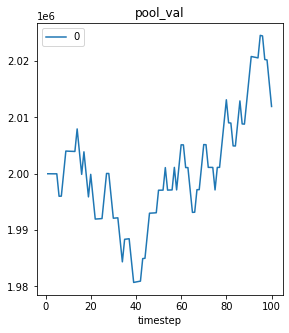

<Figure size 1080x360 with 0 Axes>

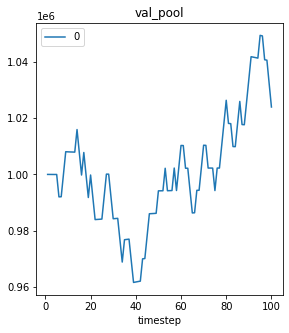

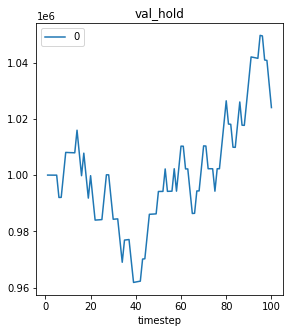

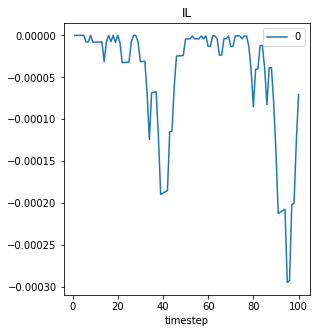

<Figure size 1080x360 with 0 Axes>

In [12]:
var_list = ['pool_val', 'pool_loss', 'val_pool', 'val_hold', 'IL', 'pool_loss']
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
pu.plot_vars(LP1_merged_df, var_list)